In [ ]:
import numpy as np
import random
import torch
import torch.nn as nn  
import torch.nn.functional as F
from collections import namedtuple, deque
import torch.optim as optim
import datetime
import gym
from gym.wrappers.record_video import RecordVideo
import glob
import io
import base64
import matplotlib.pyplot as plt
from IPython.display import HTML
from pyvirtualdisplay import Display
import tensorflow as tf
from IPython import display as ipythondisplay
from PIL import Image
import tensorflow_probability as tfp

In [ ]:
'''
Please refer to the first tutorial for more details on the specifics of environments
We've only added important commands you might find useful for experiments.
'''

'''
List of example environments
(Source - https://gym.openai.com/envs/#classic_control)

'Acrobot-v1'
'Cartpole-v1'
'MountainCar-v0'
'''

env = gym.make('MountainCar-v0')
env.seed(0)

state_shape = env.observation_space.shape[0]
no_of_actions = env.action_space.n

print(state_shape)
print(no_of_actions)
print(env.action_space.sample())
print("----")

'''
# Understanding State, Action, Reward Dynamics

The agent decides an action to take depending on the state.

The Environment keeps a variable specifically for the current state.
- Everytime an action is passed to the environment, it calculates the new state and updates the current state variable.
- It returns the new current state and reward for the agent to take the next action

'''

state = env.reset()   
''' This returns the initial state (when environment is reset) '''

print(state)
print("----")

action = env.action_space.sample()  
''' We take a random action now '''

print(action)
print("----")

next_state, reward, done, info = env.step(action) 
''' env.step is used to calculate new state and obtain reward based on old state and action taken  ''' 

print(next_state)
print(reward)
print(done)
print(info)
print("----")

4
2
0
----
[ 0.01369617 -0.02302133 -0.04590265 -0.04834723]
----
0
----
[ 0.01323574 -0.21745604 -0.04686959  0.22950698]
1.0
False
{}
----


/opt/homebrew/lib/python3.10/site-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


In [ ]:
'''
### Q Network & Some 'hyperparameters'
QNetwork1:
Input Layer - 4 nodes (State Shape) \
Hidden Layer 1 - 64 nodes \
Hidden Layer 2 - 64 nodes \
Output Layer - 2 nodes (Action Space) \
Optimizer - zero_grad()

QNetwork2: Feel free to experiment more
'''

import torch
import torch.nn as nn  
import torch.nn.functional as F


'''
Bunch of Hyper parameters (Which you might have to tune later **wink wink**)
'''
BUFFER_SIZE = int(1e5)  # replay buffer size 
BATCH_SIZE = 64         # minibatch size 
GAMMA = 0.99            # discount factor
LR = 5e-4               # learning rate 
UPDATE_EVERY = 20       # how often to update the network (When Q target is present) 


class QNetwork1(nn.Module):

    def __init__(self, state_size, action_size, seed, fc1_units=128, fc2_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(QNetwork1, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [ ]:
import random
import torch
import numpy as np
from collections import deque, namedtuple

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
    
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [ ]:
class EGreedyTutorialAgent():

    def __init__(self, state_size, action_size, seed):

        ''' Agent Environment Interaction '''
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        ''' Q-Network '''
        self.qnetwork_local = QNetwork1(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork1(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        ''' Replay memory '''
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)

        ''' Initialize time step (for updating every UPDATE_EVERY steps)           -Needed for Q Targets '''
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):

        ''' Save experience in replay memory '''
        self.memory.add(state, action, reward, next_state, done)
        
        ''' If enough samples are available in memory, get random subset and learn '''
        if len(self.memory) >= BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

        """ +Q TARGETS PRESENT """
        ''' Updating the Network every 'UPDATE_EVERY' steps taken '''      
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:

            self.qnetwork_target.load_state_dict(self.qnetwork_local.state_dict())

    def act(self, state, eps=0.):

        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        ''' Epsilon-greedy action selection (Already Present) '''
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """ +E EXPERIENCE REPLAY PRESENT """
        states, actions, rewards, next_states, dones = experiences

        ''' Get max predicted Q values (for next states) from target model'''
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)

        ''' Compute Q targets for current states '''
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        ''' Get expected Q values from local model '''
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        ''' Compute loss '''
        loss = F.mse_loss(Q_expected, Q_targets)

        ''' Minimize the loss '''
        self.optimizer.zero_grad()
        loss.backward()
        
        ''' Gradiant Clipping '''
        """ +T TRUNCATION PRESENT """
        for param in self.qnetwork_local.parameters():
            param.grad.data.clamp_(-1, 1)
            
        self.optimizer.step()


In [ ]:
# ''' Defining DQN Algorithm '''

# state_shape = env.observation_space.shape[0]
# action_shape = env.action_space.n

# def dqn(n_episodes=10000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):

#     scores = []                 
#     ''' list containing scores from each episode '''

#     scores_window_printing = deque(maxlen=10) 
#     ''' For printing in the graph '''
    
#     scores_window= deque(maxlen=100)  
#     ''' last 100 scores for checking if the avg is more than 195 '''

#     eps = eps_start                    
#     ''' initialize epsilon '''

#     for i_episode in range(1, n_episodes+1):
#         state = env.reset()
#         score = 0
#         for t in range(max_t):
#             action = agent.act(state, eps)
#             next_state, reward, done, _ = env.step(action)
#             agent.step(state, action, reward, next_state, done)
#             state = next_state
#             score += reward
#             if done:
#                 break 

#         scores_window.append(score)       
#         scores_window_printing.append(score)   
#         ''' save most recent score '''           

#         eps = max(eps_end, eps_decay*eps) 
#         ''' decrease epsilon '''

#         print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")  
#         if i_episode % 10 == 0: 
#             scores.append(np.mean(scores_window_printing))    
#         if i_episode % 100 == 0: 
#             print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
#         if np.mean(scores_window)>=195.0:
#             print('\n\rEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
#             break
#     return [np.array(scores),i_episode-100]

# ''' Trial run to check if algorithm runs and saves the data '''

# begin_time = datetime.datetime.now()
# agent = EGreedyTutorialAgent(state_size=state_shape,action_size = action_shape,seed = 0)


# result = dqn()


# time_taken = datetime.datetime.now() - begin_time

# print(time_taken)

Episode 100	Average Score: 38.24
Episode 200	Average Score: 152.55
Episode 227	Average Score: 172.56

KeyboardInterrupt: 

In [ ]:
class SoftmaxTutorialAgent():

    def __init__(self, state_size, action_size, seed):

        ''' Agent Environment Interaction '''
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        ''' Q-Network '''
        self.qnetwork_local = QNetwork1(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork1(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        ''' Replay memory '''
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)

        ''' Initialize time step (for updating every UPDATE_EVERY steps)           -Needed for Q Targets '''
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):

        ''' Save experience in replay memory '''
        self.memory.add(state, action, reward, next_state, done)
        
        ''' If enough samples are available in memory, get random subset and learn '''
        if len(self.memory) >= BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

        """ +Q TARGETS PRESENT """
        ''' Updating the Network every 'UPDATE_EVERY' steps taken '''      
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:

            self.qnetwork_target.load_state_dict(self.qnetwork_local.state_dict())

    def act(self, state, tau=0.):

        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()
        q_values = action_values.cpu().data.numpy()[0]
        _max = np.max(q_values)
        numerator = np.exp((q_values - _max)/tau)
        denominator = np.sum(numerator)
        prob = numerator / denominator
        arm_id_selected = np.random.choice(np.arange(self.action_size), p = prob)
        ''' Epsilon-greedy action selection (Already Present) '''
        return arm_id_selected

    def learn(self, experiences, gamma):
        """ +E EXPERIENCE REPLAY PRESENT """
        states, actions, rewards, next_states, dones = experiences

        ''' Get max predicted Q values (for next states) from target model'''
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)

        ''' Compute Q targets for current states '''
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        ''' Get expected Q values from local model '''
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        ''' Compute loss '''
        loss = F.mse_loss(Q_expected, Q_targets)

        ''' Minimize the loss '''
        self.optimizer.zero_grad()
        loss.backward()
        
        ''' Gradiant Clipping '''
        """ +T TRUNCATION PRESENT """
        for param in self.qnetwork_local.parameters():
            param.grad.data.clamp_(-1, 1)
            
        self.optimizer.step()

In [ ]:
state_shape = env.observation_space.shape[0]
action_shape = env.action_space.n

def dqn(n_episodes=10000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, agent = None):

    scores = []                 
    ''' list containing scores from each episode '''

    scores_window_printing = deque(maxlen=10) 
    ''' For printing in the graph '''
    
    scores_window= deque(maxlen=100)  
    ''' last 100 scores for checking if the avg is more than 195 '''

    eps = eps_start                    
    ''' initialize epsilon '''

    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 

        scores_window.append(score)       
        scores_window_printing.append(score)   
        ''' save most recent score '''           

        eps = max(eps_end, eps_decay*eps) 
        ''' decrease epsilon '''

        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")  
        if i_episode % 10 == 0: 
            scores.append(np.mean(scores_window_printing))        
        if i_episode % 100 == 0: 
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=195.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            break
    return [np.array(scores),i_episode-100]

''' Trial run to check if algorithm runs and saves the data '''

begin_time = datetime.datetime.now()
agent = SoftmaxTutorialAgent(state_size=state_shape,action_size = action_shape,seed = 0, agent = agent)


softmax_result = dqn()


time_taken = datetime.datetime.now() - begin_time

print(time_taken)

Episode 52	Average Score: 75.04

KeyboardInterrupt: 

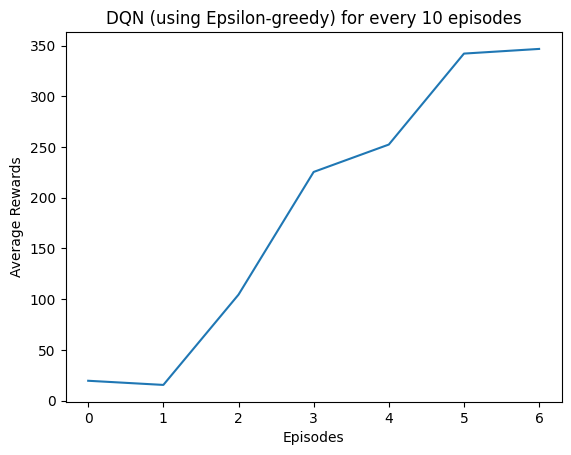

In [ ]:
ep = [i for i in range(len(result[0]))]
plt.title('DQN (using Epsilon-greedy) for every 10 episodes')
plt.xlabel('Episodes')
plt.ylabel('Average Rewards')
plt.plot(ep, result[0])
plt.show()

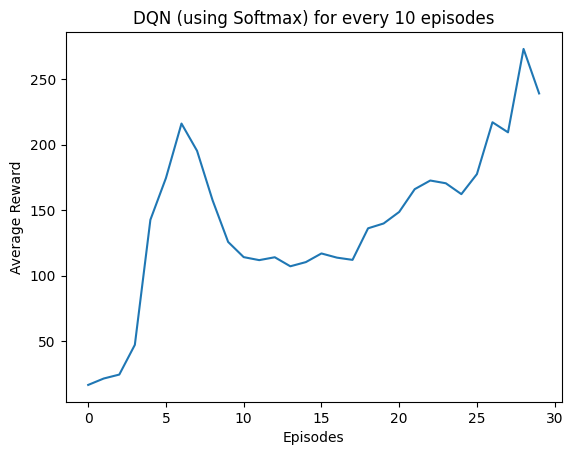

In [ ]:
ep = [i for i in range(len(softmax_result[0]))]
plt.title('DQN (using Softmax) for every 10 episodes')
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.plot(ep, softmax_result[0])
plt.show()

In [ ]:
def run10times(_type = "egreddy"):
    if _type == "egreedy":
        final_result = []
        for run in range(10):
            begin_time = datetime.datetime.now()
            agent = EGreedyTutorialAgent(state_size=state_shape,action_size = action_shape,seed = 0)
            result = dqn(agent=agent)
            time_taken = datetime.datetime.now() - begin_time
            final_result.append(result)
            
        final_result = np.array(final_result)
        final_result = np.average(final_result, axis = 1)
        ep = [i for i in range(len(final_result[0]))]
        plt.title('DQN (using Epsilon-greedy) for every 10 episodes')
        plt.xlabel('Episodes')
        plt.ylabel('Average Rewards')
        plt.plot(ep, result[0])
        plt.savefig("egreedy_params.png")
    elif _type == "softmax":
        final_result = []
        for run in range(10):
            begin_time = datetime.datetime.now()
            agent = SoftmaxTutorialAgent(state_size=state_shape,action_size = action_shape,seed = 0)
            result = dqn(agent=agent)
            time_taken = datetime.datetime.now() - begin_time
            final_result.append(result)
            
        final_result = np.array(final_result)
        final_result = np.average(final_result, axis = 1)
        ep = [i for i in range(len(final_result[0]))]
        plt.title('DQN (using Softmax) for every 10 episodes')
        plt.xlabel('Episodes')
        plt.ylabel('Average Rewards')
        plt.plot(ep, result[0])
        plt.savefig("softmax_params.png")


In [ ]:
# class ActorCriticModel(tf.keras.Model):
#         """
#         Defining policy and value networkss
#         """
#         def __init__(self, action_size, n_hidden1=1024, n_hidden2=512):
#             super(ActorCriticModel, self).__init__()

#             #Hidden Layer 1
#             self.fc1 = tf.keras.layers.Dense(n_hidden1, activation='relu')
#             #Hidden Layer 2
#             self.fc2 = tf.keras.layers.Dense(n_hidden2, activation='relu')
            
#             #Output Layer for policy
#             self.pi_out = tf.keras.layers.Dense(action_size, activation='softmax')
#             #Output Layer for state-value
#             self.v_out = tf.keras.layers.Dense(1)

#         def call(self, state):
#             """
#             Computes policy distribution and state-value for a given state
#             """
#             layer1 = self.fc1(state)
#             layer2 = self.fc2(layer1)

#             pi = self.pi_out(layer2)
#             v = self.v_out(layer2)

#             return pi, v


In [ ]:
# class Agent:
#     """
#     Agent class
#     """
#     def __init__(self, action_size, lr=0.001, gamma=0.99, seed = 85, n_step = 1):
#         self.gamma = gamma
#         self.ac_model = ActorCriticModel(action_size=action_size)
#         self.ac_model.compile(tf.keras.optimizers.Adam(learning_rate=lr))
#         np.random.seed(seed)
#         self.rewards = []
    
#     def sample_action(self, state):
#         """
#         Given a state, compute the policy distribution over all actions and sample one action
#         """
#         pi,_ = self.ac_model(state)

#         action_probabilities = tfp.distributions.Categorical(probs=pi)
#         sample = action_probabilities.sample()

#         return int(sample.numpy()[0])

#     def actor_loss(self, action, pi, delta):
#         """
#         Compute Actor Loss
#         """
#         return -tf.math.log(pi[0,action]) * delta

#     def critic_loss(self,delta):
#         """
#         Critic loss aims to minimize TD error
#         """
#         return delta**2
    
#     def compute_n_step_return(rewards, gamma=0.99):
#         R = 0
#         returns = []
#         for step in reversed(range(len(rewards))):
#             R = rewards[step] + gamma * R 
#             returns.insert(0, R)
#         return returns

#     @tf.function
#     def learn(self, state, action, reward, next_state, done):
#         """
#         For a given transition (s,a,s',r) update the paramters by computing the
#         gradient of the total loss
#         """
#         with tf.GradientTape(persistent=True) as tape:
#             pi, V_s = self.ac_model(state)
#             _, V_s_next = self.ac_model(next_state)

#             V_s = tf.squeeze(V_s)
#             V_s_next = tf.squeeze(V_s_next)
            

#             #### TO DO: Write the equation for delta (TD error)
#             ## Write code below
#             delta = reward  + self.gamma * V_s_next - V_s
#             loss_a = self.actor_loss(action, pi, delta)
#             loss_c =self.critic_loss(delta)
#             loss_total = loss_a + loss_c

#         gradient = tape.gradient(loss_total, self.ac_model.trainable_variables)
#         self.ac_model.optimizer.apply_gradients(zip(gradient, self.ac_model.trainable_variables))


In [ ]:
# env = gym.make('CartPole-v1')

# #Initializing Agent
# agent = Agent(lr=1e-4, action_size=env.action_space.n)
# #Number of episodes
# episodes = 1800
# tf.compat.v1.reset_default_graph()

# reward_list = []
# average_reward_list = []
# begin_time = datetime.datetime.now()

# for ep in range(1, episodes + 1):
#     state = env.reset().reshape(1,-1)
#     done = False
#     ep_rew = 0
#     while not done:
#         action = agent.sample_action(state) ##Sample Action
#         next_state, reward, done, info = env.step(action) ##Take action
#         next_state = next_state.reshape(1,-1)
#         ep_rew += reward  ##Updating episode reward
#         agent.add_reward(reward)
#         agent.learn(state, action, reward, next_state, done) ##Update Parameters
#         state = next_state ##Updating State
#     reward_list.append(ep_rew)

#     if ep % 10 == 0:
#         avg_rew = np.mean(reward_list[-10:])
#         print('Episode ', ep, 'Reward %f' % ep_rew, 'Average Reward %f' % avg_rew)

#     if ep % 100:
#         avg_100 =  np.mean(reward_list[-100:])
#         if avg_100 > 195.0:
#             print('Stopped at Episode ',ep-100)
#             break

# time_taken = datetime.datetime.now() - begin_time
# print(time_taken)

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2023-03-27 16:57:50.364179: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-27 16:57:50.366230: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-03-27 16:57:51.902288: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-27 16:57:51.906852: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-27 16:57:53.231618: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


KeyboardInterrupt: 

In [ ]:
rewards_list_avg = np.convolve(reward_list, np.ones(100), 'valid')/100
ep = [i for i in range(len(rewards_list_avg))]
plt.title('Running average of previous 100 rewards')
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.plot(ep, rewards_list_avg)

ValueError: v cannot be empty

In [ ]:
# Render an episode and save as a GIF file

display = Display(visible=0, size=(400, 300))
display.start()


def render_episode(env: gym.Env, model: tf.keras.Model, max_steps: int): 
    screen = env.render(mode='rgb_array')
    im = Image.fromarray(screen)

    images = [im]
    
    state = tf.constant(env.reset(), dtype=tf.float32)
    for i in range(1, max_steps + 1):
        state = tf.expand_dims(state, 0)
        action_probs, _ = model(state)
        action = np.argmax(np.squeeze(action_probs))
        state, _, done, _ = env.step(action)
        state = tf.constant(state, dtype=tf.float32)

        # Render screen every 10 steps
        if i % 10 == 0:
            screen = env.render(mode='rgb_array')
            images.append(Image.fromarray(screen))
        
        if done:
            break
        
        return images


# Save GIF image
images = render_episode(env, agent.ac_model, 200)
image_file = 'cartpole-v1.gif'
# loop=0: loop forever, duration=1: play each frame for 1ms
images[0].save(
    image_file, save_all=True, append_images=images[1:], loop=0, duration=1)

/opt/homebrew/lib/python3.10/site-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(image_file)